In [42]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import *
import time

In [43]:
def GeneratorCity(nb_city: int = 10, size_map: tuple = (100, 100)) -> list:
    """
    Return a list of cities with random coordinates and their utility

    Arguments:
        nb_city: Number of cities
        size_map: Area of the map in this format : (max_abscissa, max_ordinate)
        display: Draw a diagram of the situation

    Return:
        An array of cities with the abscissa, ordinate and the use of each cities ;
        0 means "This city is not important" ;
        1 means "This city must be delivered" ;
        2 means "This city is the depository" ;
    """

    # Randomization of points
    abscissa = random.sample(range(0, size_map[0]), nb_city)
    ordinate = random.sample(range(0, size_map[1]), nb_city)

    # Return the list of coordinate
    return [[abscissa[i],ordinate[i]] for i in range(nb_city)]


def DefinitionCity(cities: list) -> list:
    """
    Defines the type of cities

    Arguments:
        cities: The cities
        no_delivered: Removal of undelivered cities

    Return:
        The list of cities
    """

    # Define the kind of city
    delivered = random.choices(population=[0, 1], k=len(cities))

    # Define a repository
    delivered[random.randint(1, len(cities)) - 1] = 2

    # Return the list of city
    return [[cities[i][0],cities[i][1],delivered[i]] for i in range(len(cities))]


def GeneratorGraph(cities: list, fluctuation: int = 10, fluctuation_weight: int = 10):
    """
    Return the graph of the instance

    Arguments:
        cities: The coordinate from the city in this format : [max_abscissa, max_ordinate]
        fluctuation: The rate of fluctuation of the cost of the arcs
        fluctuation_weight: The fluctuation amplitude of the cost of the arcs

    Return:
        A matrix of size [nb_city, nb_city, 3]
    """

    # Initialization of the graph matrix
    generator = np.array([[(0, 0, 0)] * len(cities)] * len(cities))

    # For each element of the graph
    for i in range(len(cities)):
        for j in range(len(cities)):
            if i != j:
                # Traffic randomization
                arc_fluctuation = random.randrange(1, fluctuation)
                # Calculation of the distance between two points
                arc_min_cost = sqrt(pow(cities[i][0] - cities[j][0], 2) + pow(cities[i][1] - cities[j][1], 2))
                # Randomization of the traffic amplitude
                arc_fluctuation_weight = random.randrange(1, fluctuation_weight) * arc_min_cost
                
                # Completion of the matrix
                generator[i][j] = (arc_fluctuation, arc_fluctuation_weight, arc_min_cost)

    # Return the matrix
    return generator


In [44]:
def CalculArc(graph: np.array([[()]]), time: float, arc: tuple) -> float:
    """
    Calculates the time needed to use an arc at a given time

    Arguments:
        graph: The graph
        time: The moment the arc is use
        arc: A tuple with (start node, end node)
    
    Return:
        The time used
    """

    # Recovering data from the arc
    a = graph[arc[0]-1][arc[1]-1][0]
    c = graph[arc[0]-1][arc[1]-1][1]
    d = graph[arc[0]-1][arc[1]-1][2]

    # Only if a fluctuation is present
    if a != 0 and c != 0:
        # Calculation of the interval of the function
        intervalle = 2*sqrt(c)/sqrt(a)
        # Time transposition on the function
        time = time % intervalle
        # Calculation of the cost of the arc
        return -1 * a * pow(time - sqrt(c)/sqrt(a), 2) + c + d
    
    else:
        # Return the minimum cost
        return d
    

In [45]:
def EnergieSum(graph: np.array([[()]]), cycle: tuple) -> float:
    """
    Calculation of the energies of the graph

    Arguments:
        graph: The graph

    Return:
        The energie of the graph
    
    """
    # Energy initialization
    energie = 0

    # For each point of the graph
    for i in range(len(cycle) - 1):
        # Add the energy of the path
        energie += CalculArc(graph, energie, (cycle[i], cycle[i+1]))
    
    return energie


def NearestNeightbor(graph: np.array([[()]]), time: float, start_city: int, cities_available: list):
    """
    Get the nearest neightbor city which isn't use

    Arguments:
        graph: The graph
        time: The start time
        start_city: The start city
        cities_available: The list of cities which are available

    Return:
        The nearest neightbor city and the add time needed
    """

    nearest_neightbor = cities_available[0]
    lowest_time = CalculArc(graph, time, (start_city, cities_available[0]))

    for cities in cities_available[1:]:
        current_time = CalculArc(graph, time, (start_city, cities))
        if current_time < lowest_time:
            lowest_time = current_time
            nearest_neightbor = cities

    if len(cities_available) > 1:
        return [nearest_neightbor] + NearestNeightbor(graph, time + lowest_time, nearest_neightbor, [city for city in cities_available if city != nearest_neightbor])
    else:
        return [nearest_neightbor]


In [49]:
def DisplayGeneratorGraph(graph: np.array([[()]])):
    """
    Print the graph

    Arguments:
        graph: The graph
    """
    
    # For each line
    for i in range(np.shape(graph)[0]):
        # Begin with the check mark character
        print("[", end="")

        # For each column
        for j in range(np.shape(graph)[1]- 1):
            # Print the value and add a comma
            print(graph[i][j], end=", ")

        # Print the last value of the line and close it
        print(str(graph[i][j+1]) + "],")


def DisplayFigure(ax, cities: list):
    """
    Display a figure with the cities

    Arguements:
        cities: The cities
    """
    
    # Get each cities and display them
    for i in range(len(cities)):
        # Display each points
        ax.scatter(cities[i][0], cities[i][1], c= "red" if cities[i][2] == 0 else "blue" if cities[i][2] == 1 else "green")
        # Set the name of each points
        ax.annotate(str(i+1), (cities[i][0], cities[i][1]))


def DisplayCycle(ax, cities: list, path: list):
    """
    Display a figure with the path

    Arguments:
        cities: The cities
        path: The path
    """

    # Display the cities
    DisplayFigure(ax, cities)
    
    # Get each arc of the path
    for i in range(len(path) - 1):
        point1 = (cities[path[i] - 1][0], cities[path[i] - 1][1])
        point2 = (cities[path[i+1] - 1][0], cities[path[i+1] - 1][1])
        # Trace the arrow
        ax.arrow(
            x = cities[path[i] - 1][0], 
            y = cities[path[i] - 1][1], 
            dx = cities[path[i+1] - 1][0] - cities[path[i] - 1][0], 
            dy = cities[path[i+1] - 1][1] - cities[path[i] - 1][1],
            head_width = 200, 
            length_includes_head=True)



--- 0.7820260524749756 seconds ---
Time cost : 670488.3487675654.
Cycle use : [711, 282, 24, 468, 718, 493, 902, 414, 852, 42, 766, 560, 725, 643, 183, 847, 497, 341, 816, 645, 681, 144, 767, 511, 485, 181, 913, 47, 628, 423, 673, 967, 897, 761, 793, 209, 588, 976, 182, 908, 299, 454, 138, 824, 509, 801, 16, 122, 75, 843, 108, 3, 703, 14, 668, 875, 796, 344, 11, 799, 920, 535, 243, 153, 943, 795, 67, 235, 130, 625, 704, 5, 342, 990, 595, 221, 453, 803, 296, 506, 134, 443, 352, 388, 837, 368, 986, 754, 346, 909, 87, 556, 985, 419, 300, 789, 841, 418, 351, 387, 555, 50, 654, 426, 808, 113, 729, 83, 558, 118, 141, 361, 956, 149, 765, 429, 966, 970, 642, 903, 489, 416, 677, 769, 591, 25, 133, 363, 327, 179, 672, 474, 811, 80, 226, 71, 790, 406, 446, 518, 51, 951, 659, 356, 515, 483, 802, 581, 427, 146, 810, 240, 842, 651, 987, 737, 848, 266, 944, 915, 979, 664, 867, 490, 845, 347, 594, 615, 819, 871, 472, 618, 887, 409, 132, 608, 390, 941, 905, 35, 237, 281, 674, 597, 759, 92, 603, 715, 29

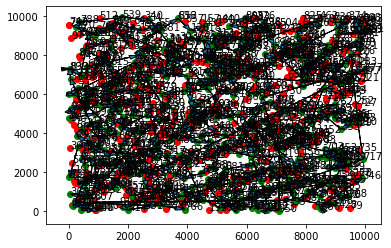

In [47]:
# Seed of generation
random.seed(a=5)

# Generator settings
nbPoints = 1000
Size_Map = (10000, 10000)
Fluctuation = 10
Fluctuation_Weight = 10

# Generation of cities
points = DefinitionCity(GeneratorCity(nbPoints, Size_Map))

# Generation of the graph
graph = GeneratorGraph(points, Fluctuation, Fluctuation_Weight)

start_time = time.time()

i = 0
while points[i][2] != 2:
    i += 1
repository = i + 1

cycle = [repository] + NearestNeightbor(graph, 0, repository, [x+1 for x, y in enumerate(points) if y[2] == 1]) + [repository]

print("--- %s seconds ---" % (time.time() - start_time))

print("Time cost : %s." % EnergieSum(graph, cycle))
print("Cycle use : " + str(cycle) + ".")
# Initiate the figure
fig, ax = plt.subplots()
DisplayCycle(ax, points, cycle)